#### 1. Import relevant modules

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from numpy import linalg as LA
from matplotlib import animation, rc
from IPython import display
import time
import copy
from IPython.core.pylabtools import figsize


#### 2. create data for aplly K-means algorithm

> **Normal_data(k, sizes, means, covs)** - create $2$ dimentional data where $k$ represent the real number of groups for classification, $size$ represent the number of samples in each class (must be at length $k$) and $mean$, $cov$ represent the mean and covariance matrix for out data which sample from (we take samples from normal disribution)

In [6]:
def Normal_data(k, sizes, means, covs):
    X = np.ndarray(shape=(0, 2))
    y = np.array([])
    for idx, (size, mean, cov) in enumerate(zip(sizes, means, covs)):
        Z = np.random.multivariate_normal(mean=mean, cov=cov, size=size)
        X = np.concatenate((X, Z), axis=0)
        y = np.concatenate((y, np.ones(shape=(size,)) * idx), axis=0)
    return X, y

k = 5
sizes = [50, 100, 100, 50]
means = [[0,2], [2, 4], [-2, -2], [4, 6]]
covs = [[[1, 0],[0, 4]], [[3, 0],[0, 5]], [[1, 0],[0, 3]], [[4, 0],[0, 2]]]

X, y = Normal_data(k=len(sizes), sizes=sizes, means=means, covs=covs)

#### 3. plot the data without the labels (for apply unsupervized algorithm)

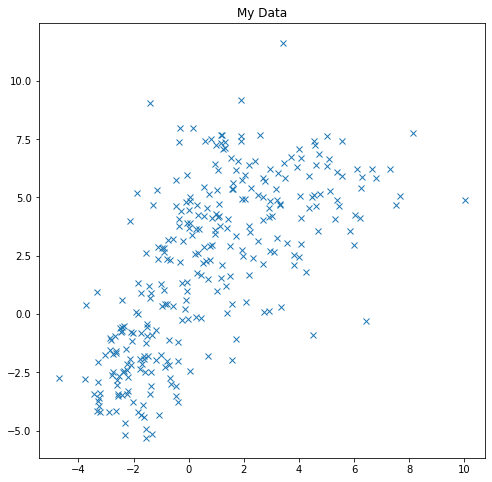

In [9]:
def Plot_data(X, dims=[0, 1], fig_size=(8, 8)):
    fig, ax = plt.subplots(1, 1, figsize=fig_size)
    ax.set_title("My Data")
    if len(dims) == 2:
        ax.plot(X[:, dims[0]], X[:, dims[1]], 'x')
    elif len(dims) == 3:
        fig.plot(X[:, dims[0]], X[:, dims[1]], 'x')
    else:
        return
    fig.show()

Plot_data(X, dims=[0, 1], fig_size=(8, 8))

#### 4. set random initialization for centers

> random_init(X, k) - take $k$ points randomly from $X$ for starting centers this method is very sensitive beacause if the centers are closed this cause to some problems in the convergance.

> random_subset(X, k, m) - take $k$ subsets of points from $X$ (where $m$ represent the ratio of the samples, for example m=0.5 is half of the data) then calculate the mean for each subset and set those valuse as the starting centers.

> random_from_circle(X, k, p_c, r, theta) - the $k$ points from $X$ at uniform random in circle with center $p_c$, radius $r > 0$ and section $0 \leq theta \leq 2 \pi$

In [10]:
def random_init(X, k):
    idx_c = np.random.choice(X.shape[0], size=k, replace=False)
    return X[idx_c, :]

def random_subset(X, k, m):
    new_C = np.ndarray(shape=(k, X.shape[1]))
    for c in range(k):
        idx_m = np.random.choice(X.shape[0], size=int(m * X.shape[0]), replace=False)
        new_C[c, :] = np.mean(X[idx_m,:], axis=0)
    return new_C

def random_from_circle(X, k, p_c, r, theta):
    R = np.expand_dims(np.random.uniform(low=min(r), high=max(r), size=k), axis=1)
    Theta = np.expand_dims(np.random.uniform(low=min(theta), high=max(theta), size=k), axis=1)
    return np.concatenate((p_c[0] + R*np.cos(Theta), p_c[1] + R*np.sin(Theta)), axis=1)


First_Centers = random_subset(X, k, m=0.8)



#### 5. Applt the K-mean algorithm

1. choose initial centers $\mu=\{\mu_i\}_{i=1}^k$
2. attribute each sample to class $C=\{1,2,...,c\}$ by $l_p$ norm, i.e.

\begin{equation}
f_p : X \rightarrow C  , \quad f_p(x) = \text{argmin}_{y \in \mu} \{ \| y-x \|_p\}
\end{equation}

3. calculate thee new centers by the average of the samples wich related to each class

\begin{equation}
\mu_0 \gets \frac{1}{|\{x \in X : f_p(x)=\mu_0|\}} \sum_{f_p(x)=\mu_0} x \quad \forall \mu_0 \in \mu
\end{equation}

3. repeat steps 2,3 untill some condition satisfied (number of iteration $T>0$ or distance between the new center the the previous centers less than $delta>0$)


In [ ]:
def Kmean(X, T, Centers):
    y_est = np.ndarray(shape=(T, X.shape[0]))
    for t in range(T):
        X_r = np.repeat(np.expand_dims(X, axis=2), Centers.shape[0], axis=2)
        Centers_r = np.repeat(np.expand_dims(Centers.T, axis=0), X.shape[0], axis=0)
        y_est[t, :] = np.argmin(LA.norm(X_r - Centers_r, ord=2, axis=1), axis=1)

        for c in range(Centers.shape[0]):
            idx = np.where(y_est[t, :] == c)[0]
            new_centers = np.mean(X[idx,:], axis=0)
            Centers[c, :] = new_centers
    return y_est


y_est = Kmean(X, T=14, Centers=First_Centers)

#### 6. Evaluation of our classification

Given a set of $n$ elements $S=\{o_{1},\ldots ,o_{n}\}$ and two partitions of $S$ to compare, $X=\{X_{1},\ldots ,X_{r}\}$ and $Y=\{Y_{1},\ldots ,Y_{s}\}$ define the following:

* $a$, the number of pairs of elements in $S$ that are in the same subset in $X$ and in the same subset in $Y$
* $b$, the number of pairs of elements in $S$ that are in different subsets in $X$ and in different subsets in $Y$
* $c$, the number of pairs of elements in $S$ that are in the same subset in $X$ and in different subsets in $Y$
* $d$, the number of pairs of elements in $S$ that are in different subsets in $X$ and in the same subset in $Y$

The Rand index, {\displaystyle R}R, is

\begin{equation}
R = \frac{a+b}{a+b+c+d} = \frac{2(a+b)}{n(n+1)}
\end{equation}

beacuse the classification can be different between samples but the imported is the relation between the clusters, thus we use in rand index metric witch rely on the relation between any pair of samples.

In [ ]:
def rand_index(y_est, y):
    res = 0
    for i in range(len(y)):
        for j in range(i + 1, len(y)):
            res += ((y[i] == y[j]) == ((y_est[i] == y_est[j])))
    return res * 200 / (len(y) * len(y) -

#### 6. Create animation of K-mean

In [4]:
def Animation_Kmean(X, Centers, y_est, y=None, dims=[0, 1]):

    min_X, max_X, min_Y, max_Y = min(X[:, 0]), max(X[:, 0]) , min(X[:, 1]), max(X[:, 1])

    fig = plt.figure(figsize=(24, 12))
    ax = plt.subplot(1,2,1)   

    ax.set_xlim((min_X - 0.1 * abs(min_X) , max_X + 0.1 * abs(max_X)))          
    ax.set_ylim((min_Y - 0.1 * abs(min_Y) , max_Y + 0.1 * abs(max_Y)))

    def drawframe(n):
        ax.clear()
        ax.set_xlim((min_X - 0.1 * abs(min_X) , max_X + 0.1 * abs(max_X)))            
        ax.set_ylim((min_Y - 0.1 * abs(min_Y) , max_Y + 0.1 * abs(max_Y)))
        txt_title = ax.set_title('')
        if n == 0:
            line, = ax.plot(X[:, dims[0]], X[:, dims[1]], 'o', ms=5)
            line.set_data(X[:, dims[0]], X[:, dims[1]])
            point, = ax.plot(Centers[:, dims[0]], Centers[:, dims[1]], 'ko', ms=10)
            txt_title.set_text(f'Iteration : {0}')
            return line, point
        data = []
        P = np.ndarray(shape=Centers.shape)
        for c in range(Centers.shape[0]):
            idx = np.where(y_est[n, :] == c)[0]
            P[c, :] = np.mean(X[idx,:], axis=0)
            line, = ax.plot([], [], 'o', ms=5)
            line.set_data(X[idx, dims[0]], X[idx, dims[1]])
            data.append(line)
        points, = ax.plot([], [], 'ko', ms=10)
        points.set_data(P[:, dims[0]], P[:, dims[1]])
        if isinstance(y,np.ndarray):
            txt_title.set_text(f'Iteration : {n}  , Rand index : {rand_index(y_est[n, :], y):2.2f} %')
        else:
            txt_title.set_text(f'Iteration : {n}')
        return data

    anim = animation.FuncAnimation(fig, drawframe, frames=y_est.shape[0], interval=300, blit=True)

    video = anim.to_html5_video()
    html = display.HTML(video)
    display.display(html)
    plt.close()


Animation_Kmean(X=X, Centers=First_Centers, y_est=y_est, y=y)